Usefull Articles:
- padding and trunctions:
https://huggingface.co/docs/transformers/pad_truncation
- Batches: 
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
- More about SEP, CLS and PAD tokens could be found in this article:
https://albertauyeung.github.io/2020/06/19/bert-tokenization.html/
  - and also in the original paper:
https://arxiv.org/pdf/1810.04805.pdf

- One hot encoding: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
  - implementing one hot: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

- The Attention mechanism: 
  - https://slds-lmu.github.io/seminar_nlp_ss20/attention-and-self-attention-for-nlp.html

- Transformers:
  - https://towardsdatascience.com/beautifully-illustrated-nlp-models-from-rnn-to-transformer-80d69faf2109#6cf1
  - https://machinelearningmastery.com/the-transformer-model/


- Softmax: https://machinelearningmastery.com/softmax-activation-function-with-python/

- Relu: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

- Pooling Layers (related to the BERT output layer): https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
    

In [1]:
# pip install transformers

In [2]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1650


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

In [4]:
df = pd.read_csv('intent_final.csv')
# df = pd.read_csv('final_df.csv')

df.head()

,prompt,intent,intent_id
0,i'm getting frequent errors when i try to acce...,performance,0
1,example:i am experiencing slow internet speeds...,performance,0
2,i'm experiencing slow download speeds on my in...,performance,0
3,my internet connection has been running extrem...,performance,0
4,my internet connection suddenly dropped and i ...,performance,0


In [5]:
df['intent'].unique()

array(['performance', 'connection', 'access', 'sonstiges'], dtype=object)

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   prompt     1200 non-null   object
 1   intent     1200 non-null   object
 2   intent_id  1200 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 28.2+ KB


In [7]:
# Initializing the BertTokenizer from the pre-trained 'bert-base-cased' model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [8]:
# Initializing the arrays to store the tokenized text

X_input_ids = np.zeros((len(df), 32))
X_attn_masks = np.zeros((len(df), 32))

In [9]:
# A Function to generate the tokenized training data

def generate_tokens(df, ids, masks, tokenizer):
    # Looping through the 'prompt' column of the dataframe

    for i, text in tqdm(enumerate(df['prompt'])):
        # Tokenizing the text
        tokenized_text = tokenizer.encode_plus(
            text, # the text to encode.
            max_length=32, # add padding to all the sentences to make them of the same length
            # padding [PAD] tokens, are added to the end of the sequence. 
            # paddings are used to ensure that all sequences in a batch have the same length. 
            # The model treats padding as non-information and does not attend to it.
            # Without padding, input sequences with different lengths would have to be processed separately, 
            #  which would increase the complexity of the model and slow down the training process.
            truncation=True,  # Truncate the sequence to the max_length
            padding='max_length', 
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                        # CLS token is used to classify the entire sequence.
                        # SEP token is used to separate two different sentences.
                        # BERT uses the first token of every sequence for classification purposes.
                        # The first token of every sequence is always a special classification token.
                        # The classification token is not used for any other purpose.
            return_tensors='tf' # Return TensorFlow tensors
        )
        # Storing the tokenized text 
        ids[i, :] = tokenized_text.input_ids # return the input ids of the tokenized text 
        masks[i, :] = tokenized_text.attention_mask # return the attnenetion masks.
        #  the attention mask in BERT is used to control the attention mechanism
        #  and ensure that the model focuses on the relevant tokens in the input sequence.
    # Returning the tokenized text
    return ids, masks

In [10]:
# calling the function and Generating the tokens for all the data
X_input_ids, X_attn_masks = generate_tokens(df, X_input_ids, X_attn_masks, tokenizer)

1200it [00:01, 1053.55it/s]


In [11]:
tokenized_text = tokenizer.convert_ids_to_tokens(X_input_ids[60])

# Print the tokenized text
print(tokenized_text)

['[CLS]', 'i', 'am', 'experiencing', 'slow', 'internet', 'speeds', 'and', 'frequent', 'connection', 'drops', 'when', 'using', 'my', 'home', 'w', '##i', '-', 'fi', 'network', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [12]:
# Initializing the array to store the labels
# second argument is the number of lables(intents)
labels = np.zeros((len(df), 4))
labels.shape

(1200, 4)

In [13]:
# Converting the 'intent_id' column of the dataframe to one-hot encoding
# The labels are populated using the values from the 'intent_id' column of the dataframe.
# np.arange(len(df)) to create an array with the same length as the dataframe "df",
# df['intent_id'].values gets the values of the "intent_id" column.
# more about one-hot could be found in the resources 
labels[np.arange(len(df)), df['intent_id'].values] = 1 

In [14]:
# Converting the data into a tensorflow dataset

dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
# Taking the first sample from the dataset

dataset.take(1) 

<TakeDataset element_spec=(TensorSpec(shape=(32,), dtype=tf.float64, name=None), TensorSpec(shape=(32,), dtype=tf.float64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [15]:
# A Function to map the data into a dictionary
#it maps the data to a dictionary that includes the input ids and attention masks, and the labels
def DatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [16]:
# Map the data into a dictionary
dataset = dataset.map(DatasetMapFunction)

In [17]:
dataset.take(1)


<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(32,), dtype=tf.float64, name=None)}, TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [18]:
# The dataset is shuffled using the 'shuffle' method (randomly rearranges the order of the elements)(with a buffer size of 10000)
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)
# A batch: is a subset of the training data used in one iteration of the training process
# Instead of training the model on the entire training dataset, the model is trained on small groups of samples.
# for memory and computational efficiency, 
# and Stochastic Behavior: Training on small batches introduces some randomness into the training process, 
# which can help the model to have a better generalization and less local minimum .
# so here batch is used to divide the dataset into batches of 16 samples each 
# and drop_remainder=True is used to drop the last batch if it has fewer than 16 samples.
# This can cause in a loss of data, if the size of the dataset is small and the batch size is large.
# but also it may not have any impact on the loss
# because over the course of many iterations, the model will loop through all the samples in the training dataset.
# 

In [19]:
# The ratio of the size of the training set
# The training set is 70% of the dataset
ratio = 0.7
train_size = int((len(df)//16)*ratio)

In [20]:
# The dataset is divided into a training set and a validation set using the 'take' and 'skip' methods. 

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [21]:
from transformers import TFBertModel

In [22]:
# Initializing the Bert model
model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
# Building the neural network
# Two input layers are created to store the input ids and attention masks
# The input ids and attention masks are passed to the BERT model to obtain the pooled output layer
# The pooled output layer is passed to a dense layer with 64 neurons and a ReLU activation function
# The output of the dense layer is passed to a dense layer with 11 neurons and a softmax activation function
# The softmax activation function is used to calculate the probabilities of the classes

# The relu activation function is used to add non-linearity into the model
# the softmax activation function is used to calculate the probabilities of the different classes.

# the input layers has a shape of (32,) which is a 1-dimensional tensor with the maximum length of 256 tokens
# 
input_ids = tf.keras.layers.Input(shape=(32,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(32,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] 
# The [1] indexing is used to extract the second element from the output of the bert method,
# which is the "pooled output layer"
# The "pooled output layer" is a feature representation obtained from a pre-trained BERT model.
intermediate_layer = tf.keras.layers.Dense(64, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(intermediate_layer) 
# the output layer has a shape of (4,) because there are 11 classes

# compiling the model with all the layers:
intents_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
intents_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 32,                                            

In [24]:
# Defining the optimizer, loss function, and accuracy metric
# The Adam optimizer is used to minimize the loss function
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6, decay=1e-5)
loss_func = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')
f1= tf.keras.metrics.CategoricalAccuracy('f1')
crossEtropy = tf.keras.metrics.CategoricalCrossentropy('crossEtropy')


In [25]:
# The model is compiled using the Adam optimizer and the sparse categorical crossentropy loss function

intents_model.compile(optimizer=adam_optimizer, loss=loss_func, metrics=[accuracy,f1,crossEtropy])

In [26]:
tf.keras.utils.plot_model(intents_model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
import matplotlib.pyplot as plt

# # training_history: Training the model
# The model is trained for 15  epochs
# The training dataset is passed to the model using the 'fit' method
# The validation dataset is passed to the model using the 'validation_data' parameter
# The model is evaluated on the validation dataset after each epoch

training_history = intents_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15 
)
#plotting the training history



Epoch 1/15
52/52 [==============================] - 25s 316ms/step - loss: 1.3880 - accuracy: 0.2776 - f1: 0.2776 - crossEtropy: 1.3880 - val_loss: 1.2841 - val_accuracy: 0.4538 - val_f1: 0.4538 - val_crossEtropy: 1.2841
Epoch 2/15
52/52 [==============================] - 14s 279ms/step - loss: 1.1864 - accuracy: 0.5060 - f1: 0.5060 - crossEtropy: 1.1864 - val_loss: 1.0967 - val_accuracy: 0.5489 - val_f1: 0.5489 - val_crossEtropy: 1.0967
Epoch 3/15
52/52 [==============================] - 15s 280ms/step - loss: 1.0566 - accuracy: 0.5529 - f1: 0.5529 - crossEtropy: 1.0566 - val_loss: 1.0137 - val_accuracy: 0.5353 - val_f1: 0.5353 - val_crossEtropy: 1.0137
Epoch 4/15
52/52 [==============================] - 15s 281ms/step - loss: 0.9285 - accuracy: 0.5986 - f1: 0.5986 - crossEtropy: 0.9285 - val_loss: 0.8328 - val_accuracy: 0.6495 - val_f1: 0.6495 - val_crossEtropy: 0.8328
Epoch 5/15
52/52 [==============================] - 15s 281ms/step - loss: 0.7873 - accuracy: 0.7007 - f1: 0.7007 - 

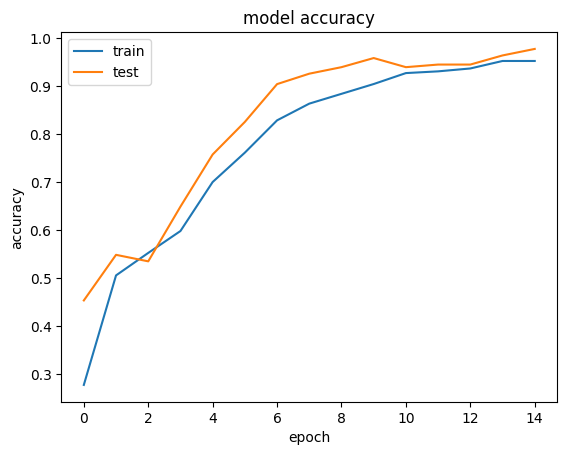

In [28]:
# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

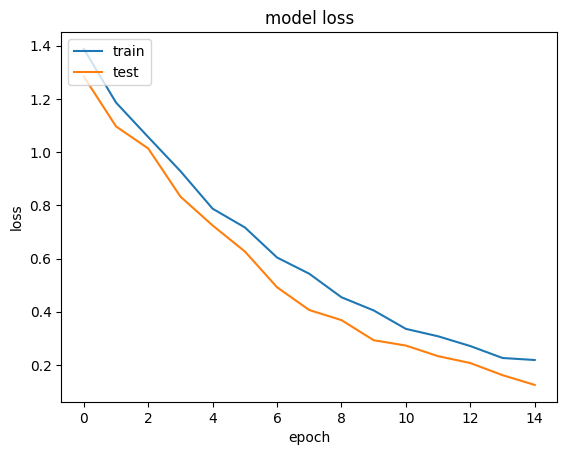

In [29]:
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
results = intents_model.evaluate(val_dataset)

23/23 [==============================] - 2s 68ms/step - loss: 0.1687 - accuracy: 0.9511 - f1: 0.9511 - crossEtropy: 0.1687


In [31]:
# Save the model
#intents_model.save('intent_model')

INFO:tensorflow:Assets written to: intent_model\assets


INFO:tensorflow:Assets written to: intent_model\assets


In [38]:
# intents_model = tf.keras.models.load_model('model')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# preparing the data that will be passed to the model as an input for testing
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=32, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['performance', 'connection', 'access', 'sonstiges']):
    # The predict method is used to pass the processed_data to the neural network
    #  and obtain the predicted class probabilities.
    # The result of the predict method is a 2-dimensional array
    # the first dimension represents the number of samples in processed_data 
    # the second dimension represents the number of classes in the output layer.
    # The indexing [0] is used to extract the predicted class probabilities
    # The np.argmax method is used to extract the index of the class with the highest probability
    # The classes map the index to its corresponding class name
    probs = model.predict(processed_data)[0]
    # returns the class with the highest probability
    return classes[np.argmax(probs)]
     

In [33]:
# input_text = input('Enter prompt here: ')
# processed_data = prepare_data(input_text, tokenizer)
# result = make_prediction(intents_model, processed_data=processed_data)
# print(f"Predicted intent: {result}")

In [39]:
# input_list=['still my printer is not displaying to an internal error message that simply says printer is not connectedeven though though today it is connected to all my computer.	','i cant connect to my email', 'I got no internet',  ' I dont have internet', ]
input_list = ["my monitor says theres no signal", "my printer gives empty cartridge error"]
def predict_list (input_list):
    for i in input_list:
        processed_data = prepare_data(i, tokenizer)
        result = make_prediction(intents_model, processed_data=processed_data)
        print(f"prompt: {i}, Predicted intent: {result}")

predict_list(input_list)

1/1 [==============================] - 0s 71ms/step
prompt: my monitor says theres no signal, Predicted intent: connection
1/1 [==============================] - 0s 72ms/step
prompt: my printer gives empty cartridge error, Predicted intent: sonstiges


In [35]:
def answerMsgBert(msg):
    processed_data = prepare_data(msg, tokenizer)
    result = make_prediction(intents_model, processed_data=processed_data)
    return result


In [36]:
answerMsgBert("my monitor says theres no signal")

1/1 [==============================] - 0s 69ms/step


'connection'